# Final Project Notebook: MovieLens Recommender System with Azure OpenAI

## Introduction: 

Recommender systems are a core component of many modern online platforms, helping users discover content that matches their interests from vast collections of items. In this project, I build and compare two approaches to recommendation using the popular [MovieLens dataset](https://grouplens.org/datasets/movielens/1m/): a **traditional Spark-based collaborative filtering pipeline**, and an **LLM-enhanced recommender system** powered by the Azure OpenAI service.  

The goal is to evaluate the performance of conventional recommendation metrics — such as Precision, Recall, and Diversity — and to test how integrating a Large Language Model (LLM) can complement or extend traditional methods by generating novel suggestions in plain language.

To demonstrate real-world deployment, this project (Project 6: Azure Hands-On) is implemented entirely on **Microsoft Azure**, using:
- **Azure Blob Storage** for persistent storage of the dataset,
- **Databricks and Spark** for scalable data processing and training,
- **Azure OpenAI** for generating recommendations with a state-of-the-art LLM,
- and secure network configurations to ensure controlled access to resources.

As part of my long-term vision, I plan to adapt this pipeline to build a **lessons or course recommender system**, which could help students or learners find relevant study materials or personalized content based on their previous engagement. This project demonstrates the feasibility and limitations of combining **traditional collaborative filtering** with modern **generative AI**, paving the way for more advanced educational applications.

In the following sections, I explain the data processing pipeline, the evaluation metrics, the deployment architecture, and finally, interpret the results and limitations of both the traditional and LLM-based recommenders.


In [0]:
%pip install -q openai

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


#### PySpark Session:
This code initializes the PySpark session using Databricks.
Creating a SparkSession is the first step for running PySpark code — it sets up the Spark engine and gives you the entry point to use Spark DataFrames, transformations, and distributed processing for large datasets.
Without this step, none of the Spark operations (like loading data, filtering, or joining) would run.

In [0]:
# Databricks / PySpark Setup
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MovieLensFinalProject").getOrCreate()
print("Spark Session created!")

Spark Session created!


## 1. Mount Azure Blob Storage (Persistent Storage)

#### My Blob Storage:
This code mounts my Azure Blob Storage container to Databricks.
By doing this, I connect the remote storage account (movielensstorage123) and the specific container (movielensdata) to the Databricks file system at the local mount point /mnt/movielens.
This allows me to easily read and write files from the cloud storage as if they were part of the Databricks workspace.
The if check ensures that the container is not mounted twice — if it’s already mounted, it skips remounting.
This step is essential for providing persistent cloud storage, which is a requirement for the Azure hands-on component of my project.

In [0]:
# Mount Blob Storage
storage_account_name = "movielensstorage123"
container_name = "movielensdata"
mount_point = "/mnt/movielens"

# Get the key from Spark env
storage_account_key = spark.conf.get("spark.env.STORAGE_ACCOUNT_KEY")

if not any(mount.mountPoint == mount_point for mount in dbutils.fs.mounts()):
    dbutils.fs.mount(
        source = f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net",
        mount_point = mount_point,
        extra_configs = {
            f"fs.azure.account.key.{storage_account_name}.blob.core.windows.net": storage_account_key
        }
    )
    print(f"Mounted at {mount_point}")
else:
    print(f"Already mounted at {mount_point}")

Already mounted at /mnt/movielens


## 2. Load Data
This code loads the MovieLens dataset from my mounted Azure Blob Storage into Spark DataFrames.
Specifically, it reads two files:
  - `ratings.dat` — which contains user ratings for movies, with columns for userId, movieId, rating, and timestamp.
  - `movies.dat` — which includes movie details like movieId, title, and genres.

After loading, I rename the columns and explicitly cast each column to the correct data type (integers for IDs, float for ratings, long for timestamps) to ensure proper downstream processing.

Finally, I show the first few rows of each DataFrame to verify that the data has been loaded correctly.

This step demonstrates how Spark can efficiently handle large files stored remotely in Azure Blob Storage, forming the foundation for the recommendation system.

In [0]:
# Load Data
ratings_df = spark.read.option("delimiter", "::") \
                       .option("inferSchema", True) \
                       .csv(f"{mount_point}/ratings.dat")

from pyspark.sql.functions import col

ratings_df = ratings_df.toDF("userId", "movieId", "rating", "timestamp")

ratings_df = ratings_df.withColumn("userId", col("userId").cast("int")) \
                       .withColumn("movieId", col("movieId").cast("int")) \
                       .withColumn("rating", col("rating").cast("float")) \
                       .withColumn("timestamp", col("timestamp").cast("long"))

movies_df = spark.read.option("delimiter", "::").csv(f"{mount_point}/movies.dat")
movies_df = movies_df.toDF("movieId", "title", "genres")

# Show sample
ratings_df.show(5)
movies_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|   1193|   5.0|978300760|
|     1|    661|   3.0|978302109|
|     1|    914|   3.0|978301968|
|     1|   3408|   4.0|978300275|
|     1|   2355|   5.0|978824291|
+------+-------+------+---------+
only showing top 5 rows
+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Animation|Childre...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|        Comedy|Drama|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows


The code below saves the Spark `movies_df` DataFrame to a CSV file in my mounted Azure Blob Storage.          
First, I convert the Spark DataFrame to a Pandas DataFrame so I can use the `to_csv()` method, which writes the data to a CSV file.     
The output path `/dbfs/mnt/movielens/movies.csv` places the file inside Databricks File System (DBFS), which is mounted directly to my Azure Blob Storage container.
This step shows how Spark and Databricks can easily export processed data back to persistent cloud storage for later use, sharing, or external access.

In [0]:
# Save the Spark dataframe to CSV on DBFS (Databricks File System)
csv_path = "/dbfs/mnt/movielens/movies.csv"

# Convert to pandas dataframe and save
movies_df.toPandas().to_csv(csv_path, index=False)

## 3. Data Cleaning & Type Casting
This code performs additional data cleaning and type casting on my DataFrames.      
I explicitly cast the `userId`, `movieId`, `rating`, and `timestamp` columns in `ratings_df` to their appropriate data types (integers, float, long) to ensure consistency and correct behavior during analysis and model training.       
Similarly, I cast the `movieId` in `movies_df` to integer to align with `ratings_df`.       
Doing this step guarantees that joins, filters, and calculations will work properly without unexpected type mismatches — which is crucial for building a reliable recommender system.

In [0]:
#  Data Cleaning & Type Casting
from pyspark.sql.functions import col

ratings_df = ratings_df.withColumn("userId", col("userId").cast("int")) \
                       .withColumn("movieId", col("movieId").cast("int")) \
                       .withColumn("rating", col("rating").cast("float")) \
                       .withColumn("timestamp", col("timestamp").cast("long"))

movies_df = movies_df.withColumn("movieId", col("movieId").cast("int"))

## 4.
### 4.1 Enrich Movies Data: Extract Genres as Array
This code enriches the `movies_df` DataFrame with structured content features by splitting the `genres` column into an array of individual genres.      
The original `genres` field is a single string with genres separated by the `|` character (e.g., `"Comedy|Drama"`).       
Using Spark’s `split()` function, I convert this into an array of genre values for each movie, making it easier to work with during similarity calculations or diversity metrics.
I display the result to verify that the genres are now stored as clean lists, which improves the quality of content-based filtering and advanced metrics later on.

In [0]:
# Enrich with Content Features
# Extract genres from movies_df (I join in scraped taglines and poster paths -if available- in next code chunk)
from pyspark.sql.functions import split

movies_df = movies_df.withColumn("genres", split(col("genres"), "\\|"))
movies_df.select("movieId", "title", "genres").show(5, truncate=False)

+-------+----------------------------------+--------------------------------+
|movieId|title                             |genres                          |
+-------+----------------------------------+--------------------------------+
|1      |Toy Story (1995)                  |[Animation, Children's, Comedy] |
|2      |Jumanji (1995)                    |[Adventure, Children's, Fantasy]|
|3      |Grumpier Old Men (1995)           |[Comedy, Romance]               |
|4      |Waiting to Exhale (1995)          |[Comedy, Drama]                 |
|5      |Father of the Bride Part II (1995)|[Comedy]                        |
+-------+----------------------------------+--------------------------------+
only showing top 5 rows


### 4.2 Enrich Movies Data with additional features
This code uses the TMDb API to enrich the MovieLens movies with additional content features: taglines, poster paths, and TMDb IDs.

First, it loads the `movies.csv` file (previously saved from Spark) into a Pandas DataFrame. Then, for each movie, it extracts the movie title and release year, searches the TMDb API for a matching movie, and retrieves its `tagline` and `poster_path` if available.

This loop also respects TMDb’s API rate limits with a short sleep between requests. Once all details are fetched, the new information (`tmdb_id`, `tagline`, `poster_path`) is added as new columns in the DataFrame.

Finally, the enriched movie data is saved back as `scraped_taglines.csv` directly in the mounted Azure Blob Storage container.

This step demonstrates how external data can be integrated to enhance content-based features, making the recommender system richer and more flexible — for example, taglines could be used for natural language similarity or metadata-driven recommendations.

In [0]:
import pandas as pd
import requests
import time

# ✅ Get TMDb API key from Spark environment
API_KEY = spark.conf.get("spark.env.TMDB_API_KEY")

# ✅ Input MovieLens CSV
INPUT_CSV = "/dbfs/mnt/movielens/movies.csv"

# ✅ Output file — save directly in your mount!
OUTPUT_CSV = "/dbfs/mnt/movielens/scraped_taglines.csv"

# Load movies
movies = pd.read_csv(INPUT_CSV)

# Extract year
movies["year"] = movies["title"].str.extract(r"\((\d{4})\)").astype(float)

taglines = []
poster_paths = []
tmdb_ids = []

for idx, row in movies.iterrows():
    title = row["title"].split("(")[0].strip()
    year = int(row["year"]) if not pd.isna(row["year"]) else None

    # Search TMDb
    search_url = "https://api.themoviedb.org/3/search/movie"
    params = {"api_key": API_KEY, "query": title}
    if year:
        params["year"] = year

    response = requests.get(search_url, params=params)
    data = response.json()

    if "results" in data and data["results"]:
        tmdb_id = data["results"][0]["id"]
        tmdb_ids.append(tmdb_id)

        # Get movie details
        details_url = f"https://api.themoviedb.org/3/movie/{tmdb_id}"
        details_params = {"api_key": API_KEY}
        details_resp = requests.get(details_url, params=details_params)
        details = details_resp.json()

        tagline = details.get("tagline", "")
        poster_path = details.get("poster_path", "")

        taglines.append(tagline)
        poster_paths.append(poster_path)
    else:
        tmdb_ids.append(None)
        taglines.append("")
        poster_paths.append("")

    # Respect TMDb rate limits
    time.sleep(0.25)

# Add results to DataFrame
movies["tmdb_id"] = tmdb_ids
movies["tagline"] = taglines
movies["poster_path"] = poster_paths

# ✅ Save directly to your container
movies.to_csv(OUTPUT_CSV, index=False)

print(f"✅ Done! Saved to {OUTPUT_CSV}")

✅ Done! Saved to /dbfs/mnt/movielens/scraped_taglines.csv


This code loads the enriched movie data with taglines and poster paths back into Spark and joins it with the original `movies_df`.

First, it reads the `scraped_taglines.csv` file (created in the previous step) into a new Spark DataFrame, `taglines_df`. Then it performs a left join to merge the new columns (`tagline` and `poster_path`) into the original `movies_df` based on the `movieId`.

The result, `movies_enriched_df`, now includes structured genres and descriptive taglines for each movie, as well as poster image paths. Displaying the first few rows confirms that the join worked as expected.

This step completes the content enrichment pipeline, combining MovieLens metadata with external TMDb information — which can improve the recommender system’s ability to generate more context-aware or visually rich suggestions.

In [0]:
# Read the scraped taglines with Spark
taglines_df = spark.read.csv("dbfs:/mnt/movielens/scraped_taglines.csv", header=True, inferSchema=True)

# Join with your original movies_df
movies_enriched_df = movies_df.join(
    taglines_df.select("movieId", "tagline", "poster_path"),
    on="movieId",
    how="left"
)

# Combine genres + tagline
from pyspark.sql.functions import concat_ws, col

movies_enriched_df = movies_enriched_df.withColumn(
    "content",
    concat_ws(" ", col("genres"), col("tagline"))
)

movies_enriched_df.select("movieId", "title", "genres", "tagline", "content").show(5, truncate=False)

+-------+----------------------------------+-------------------------------+------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+
|movieId|title                             |genres                         |tagline                                                                       |content                                                                                    |
+-------+----------------------------------+-------------------------------+------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+
|1      |Toy Story (1995)                  |[Animation, Children's, Comedy]|The adventure takes off when toys come to life!                               |Animation Children's Comedy The adventure takes off when toys come to life!                |
|6      

## 5. Train/Test Split (Last rating per user as test)

The code below splits the MovieLens ratings data into training and test sets using a time-based strategy.

First, it defines a Spark `Window` that partitions the data by `userId` and orders each user’s ratings by `timestamp` in descending order. It then adds a `row_num` column to mark the most recent rating for each user as `1`.

The most recent rating for each user is selected as the test set (`test_df`), simulating a realistic scenario where the recommender must predict future interactions. All other ratings are used for training (`train_df`).

The final `print` statement confirms the sizes of the splits, showing that the system will train on over **990,000 ratings** and evaluate on about **6,000 holdout interactions** — ensuring a robust and fair offline evaluation.

In [0]:
# Train/Test Split
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

window = Window.partitionBy("userId").orderBy(col("timestamp").desc())
ratings_df = ratings_df.withColumn("row_num", row_number().over(window))

test_df = ratings_df.filter(col("row_num") == 1).drop("row_num")
train_df = ratings_df.filter(col("row_num") > 1).drop("row_num")

print(f"Train count: {train_df.count()}, Test count: {test_df.count()}")

Train count: 994169, Test count: 6040


## 6. Baseline: Global Average Rating

This simple baseline predicts the same rating for every user–movie pair using just the global mean of all ratings in the training set.

**_How it works:_**

- Calculates the overall average rating across all users and movies.

- Uses that single number as the predicted rating for any unseen movie.

**_Why include it?_**

- This is the most basic benchmark — any useful recommender must do better than guessing the same number every time.

- Comparing RMSE or MAE against this naive predictor shows how much more signal your collaborative, content-based, or LLM systems add.

**_Output:_**

- Prints the global average, **3.58**, which would be used as the prediction for all test ratings.

In [0]:
from pyspark.sql.functions import avg

global_avg = train_df.select(avg(col("rating")).alias("global_avg")).collect()[0]["global_avg"]
print(f"Global average rating: {global_avg:.4f}")

Global average rating: 3.5814


**Interpretations:**

The global average rating serves as a simple baseline for recommendations. It shows that users in this dataset tend to rate movies slightly above the midpoint on the 1–5 scale.

Many traditional algorithms (such as **collaborative filtering** or **matrix factorization**) use this global mean as a starting point, adjusting predictions by learning how specific users and items deviate from it.

In practice, a recommender system should significantly outperform this trivial baseline by delivering personalized predictions closer to each user’s true preferences.

## 7. Baseline: User and Item Biases

This block refines the global average by adding simple bias adjustments for users and items:

**_How it works:_**

- **User Mean:** Accounts for the fact that some users tend to rate higher or lower than average. For example, a user who always gives 5 stars will have a higher user bias.

- **Item Mean:** Accounts for the fact that some movies tend to get higher or lower average ratings than others (classics vs. flops).

_**Why include it?**_

- This is a stronger baseline than the pure global average — it personalizes predictions slightly by shifting them based on user and item tendencies.

- It shows whether your more advanced models (ALS, content-based, LLM) can capture more complex interactions beyond these simple linear effects.

**_Output:_**

- Displays the average rating for a few users and items, showing how each differs from the global mean.

In [0]:
user_avg = train_df.groupBy("userId").agg({"rating": "avg"}).withColumnRenamed("avg(rating)", "user_avg")
item_avg = train_df.groupBy("movieId").agg({"rating": "avg"}).withColumnRenamed("avg(rating)", "item_avg")

user_avg.show(5)
item_avg.show(5)

+------+------------------+
|userId|          user_avg|
+------+------------------+
|     1| 4.173076923076923|
|    12|3.8636363636363638|
|    22| 3.064189189189189|
|    26|2.9649122807017543|
|    27| 4.159420289855072|
+------+------------------+
only showing top 5 rows
+-------+------------------+
|movieId|          item_avg|
+-------+------------------+
|    833|2.1794871794871793|
|   1580|3.7390099009900992|
|   2122|2.4347826086956523|
|    463|  2.74468085106383|
|   1645| 3.432926829268293|
+-------+------------------+
only showing top 5 rows


**Interpretation:**

This baseline shows how **individual users** tend to rate differently (some are harsh, some are generous), and how some movies are consistently liked or disliked.

For example, the sample output shows that **User 1** has an average rating of about **4.17**, which is well above the global average of **3.58** — meaning they generally rate movies higher than average.

Similarly, **Movie 833** has an average rating of **2.17**, suggesting it is generally disliked.

Many recommender systems use these user and item biases to adjust predictions — for example, matrix factorization models predict:

> *predicted rating = global average + user bias + item bias*

This baseline helps explain part of the variation in ratings using simple statistics before **learning complex latent factors**.

## 8. Popularity-Based Recommender

This block implements a popularity-based recommender, another simple baseline that ignores personal preferences.

_**How it works:**_

- It counts how many ratings each movie has in the training set to measure its overall popularity.

- For each user, it recommends the top-N most popular movies they haven’t seen yet.

- It uses crossJoin and left_anti to filter out movies the user has already rated.

**_Why compare?_**

- Popularity-based recommendations are a practical real-world baseline — for example, streaming services often promote trending or blockbuster content.

- Unlike the ALS model (collaborative) or the TF-IDF model (content-based with taglines), this approach does not personalize recommendations beyond removing already-watched items.

- Comparing your popularity-only results to collaborative, content-based, and LLM-generated recommendations shows how much personalized models improve over simple “most popular” lists.

**_Outputs:_**

- The first table shows the most popular movies overall.

- The final output shows sample movie recommendations for each user, based purely on popularity.

In [0]:
from pyspark.sql.functions import count

movie_popularity = train_df.groupBy("movieId").agg(count("*").alias("num_ratings")) \
    .join(movies_df, "movieId") \
    .orderBy(col("num_ratings").desc())

movie_popularity.show(10)

from pyspark.sql.functions import desc

# Step 1: Count popularity
movie_pop = train_df.groupBy("movieId").agg(count("*").alias("popularity"))
movie_pop = movie_pop.orderBy(desc("popularity"))

# Step 2: For each user, recommend top-N popular movies they haven't seen
user_seen = train_df.select("userId", "movieId")
users = train_df.select("userId").distinct()
top_movies = movie_pop.limit(100)  # adjust N as needed

# Cross join users with top movies, then filter out seen
from pyspark.sql.functions import broadcast

pop_recs = (
    users.crossJoin(broadcast(top_movies.select("movieId")))
    .join(broadcast(user_seen), ["userId", "movieId"], "left_anti")
    .select("userId", "movieId")
)

pop_recs.show(10)

+-------+-----------+--------------------+--------------------+
|movieId|num_ratings|               title|              genres|
+-------+-----------+--------------------+--------------------+
|   2858|       3398|American Beauty (...|     [Comedy, Drama]|
|   1196|       2984|Star Wars: Episod...|[Action, Adventur...|
|    260|       2971|Star Wars: Episod...|[Action, Adventur...|
|   1210|       2879|Star Wars: Episod...|[Action, Adventur...|
|    480|       2659|Jurassic Park (1993)|[Action, Adventur...|
|   2028|       2650|Saving Private Ry...|[Action, Drama, War]|
|    589|       2618|Terminator 2: Jud...|[Action, Sci-Fi, ...|
|   2571|       2577|  Matrix, The (1999)|[Action, Sci-Fi, ...|
|   1270|       2570|Back to the Futur...|    [Comedy, Sci-Fi]|
|    593|       2558|Silence of the La...|   [Drama, Thriller]|
+-------+-----------+--------------------+--------------------+
only showing top 10 rows
+------+-------+
|userId|movieId|
+------+-------+
|     1|   2858|
|     6|   

**Interpretation:**  

From the output, we can see that *American Beauty (1999)*, *Star Wars*, *Jurassic Park*, *Saving Private Ryan*, etc. are among the top recommended movies because they have the most ratings in the dataset.  
This baseline shows how simple popularity can drive recommendations, but it does not personalize for user preferences — which more advanced methods will improve on.

## 9. Content-Based Filtering 

#### TF-IDF Feature Creation

This block prepares a text representation for each movie by combining its `genres` and `tagline` into one `content` field and then converting that text into numerical features using TF-IDF (Term Frequency–Inverse Document Frequency).

- **Tokenizer:** Splits the `content` text into individual words.

- **HashingTF:** Maps the words to a fixed-length vector using hashing and counts the word occurrences.
    
- **IDF:** Scales the word counts by how rare each word is across all movies — giving more weight to distinctive words.

✅ **Purpose:** This turns each movie’s combined genre + tagline into a vector that captures its unique content characteristics.

In [0]:
# Build the TF-IDF pipeline for all movies
from pyspark.ml.feature import Tokenizer, HashingTF, IDF

# Tokenize
tokenizer = Tokenizer(inputCol="content", outputCol="content_words")
words_data = tokenizer.transform(movies_enriched_df)

# TF
hashingTF = HashingTF(inputCol="content_words", outputCol="rawFeatures", numFeatures=1000)
featurized_data = hashingTF.transform(words_data)

# IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
tfidf_df = idf_model.transform(featurized_data)

tfidf_df.select("movieId", "title", "content", "features").show(5, truncate=False)

🏃 View run marvelous-grub-847 at: https://adb-1897642321259405.5.azuredatabricks.net/ml/experiments/2935295099286564/runs/def9339a9ff44a829b6219215fefd759
🧪 View experiment at: https://adb-1897642321259405.5.azuredatabricks.net/ml/experiments/2935295099286564
+-------+----------------------------------+-------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|movieId|title                             |content                                                                                    |features                                                                                                                    

#### Reusable Content-Based Recommendation Function

This section defines a general-purpose Python function that generates personalized movie recommendations for any user using the TF-IDF vectors you just built.

- Input: The user’s ID, the training ratings, and the TF-IDF movie features.

- The function filters for the movies the user liked (rated ≥ 4).

- For each liked movie, it computes the cosine similarity between its vector and every other movie’s vector.

- If the user liked multiple movies, it adds up the similarities to capture multiple interests.

- It filters out movies the user has already rated.

- Finally, it returns the top-N most similar movies as recommendations.

✅ **Purpose:** It predicts which movies are similar in content to what the user liked — using both genres and taglines.

In [0]:
# Function to generate recommendations for any user
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType

# UDF for cosine similarity
def cosine_similarity(v1, v2):
    num = float(v1.dot(v2))
    denom = float(v1.norm(2) * v2.norm(2))
    return float(num) / denom if denom != 0 else 0.0

cosine_udf = udf(cosine_similarity, DoubleType())

# Function to recommend top-N for ANY user
def recommend_content_based(user_id, liked_ratings_df, tfidf_df, top_n=10):
    # Get movies this user liked (rated >=4)
    liked_movies = liked_ratings_df.filter(col("userId") == user_id).filter(col("rating") >= 4.0)

    # Join to get content features for liked movies
    liked_vectors = liked_movies.join(tfidf_df.select("movieId", "features"), on="movieId").collect()

    # If user has no liked movies, return empty
    if len(liked_vectors) == 0:
        print(f"No liked movies for user {user_id}")
        return None

    # Initialize empty DataFrame for accumulated scores
    recs = None

    for row in liked_vectors:
        liked_vec = row["features"]

        # Define a local UDF that fixes liked_vec as a constant
        cosine_udf_fixed = udf(lambda v: cosine_similarity(liked_vec, v), DoubleType())

        # Compute similarity to all movies
        sims = tfidf_df.withColumn("similarity", cosine_udf_fixed(col("features")))

        if recs is None:
            recs = sims.select("movieId", "title", "similarity")
        else:
            recs = recs.join(
                sims.select("movieId", sims["similarity"].alias("sim2")),
                on="movieId"
            ).withColumn("similarity", col("similarity") + col("sim2")).drop("sim2")

    # Filter out already seen movies
    seen = liked_movies.select("movieId").distinct()
    recs = recs.join(seen, on="movieId", how="left_anti")

    # Rank & pick top-N
    final_recs = recs.orderBy(col("similarity").desc()).limit(top_n)

    return final_recs

#### Generate Recommendations for a Specific User

This block calls the function for a test user (for example, `userId = 1`) and displays the recommended movies.

✅ **Purpose:** Demonstrates how to get personalized content-based recommendations using your new hybrid text features — showing that your scraped tagline data really influences the output!

In [0]:
# Example: recommend for user 1
top_recs = recommend_content_based(
    user_id=1,
    liked_ratings_df=train_df,
    tfidf_df=tfidf_df,
    top_n=10
)

if top_recs:
    top_recs.show(10, truncate=False)


+-------+---------------------------------------------------------+-----------------+
|movieId|title                                                    |similarity       |
+-------+---------------------------------------------------------+-----------------+
|2102   |Steamboat Willie (1940)                                  |6.177162355795796|
|2092   |Return of Jafar, The (1993)                              |6.099149966229794|
|1024   |Three Caballeros, The (1945)                             |6.099149966229794|
|3159   |Fantasia 2000 (1999)                                     |6.099149966229794|
|48     |Pocahontas (1995)                                        |5.922210294131121|
|3054   |Pok�mon: The First Movie (1998)                          |5.397456600834284|
|3287   |Tigger Movie, The (2000)                                 |5.397456600834284|
|3799   |Pok�mon the Movie 2000 (2000)                            |5.397456600834284|
|888    |Land Before Time III: The Time of the Great G

# NEED TO MODIFY THIS PART
**Interpretation:**  
The output shows that **User 1** likes a wide range of genres — for example:
- 17 *Children’s* movies
- 21 *Drama* movies
- 13 *Animation* movies  
This insight can be used to personalize recommendations:  
If we know a user prefers *Drama* and *Animation*, we can prioritize unseen movies in these genres.

This step is useful for building **content-based recommenders** or for adding **side information** to hybrid models.

This code chunk builds a simple **content-based recommender** by using each user’s **top preferred genre(s)**:  
- First, for each user, it identifies their **most-watched genre(s)** from the `user_genres` table.
- Then, it finds movies that have matching genres.
- Finally, it pairs each user with all movies that share their top genres and that they may not have seen yet.

## 10. Collaborative Filtering: ALS Model

This code chunk implements a collaborative filtering recommender system using the ALS (Alternating Least Squares) algorithm — a popular matrix factorization technique for large-scale recommendation tasks.

**_How it works:_**

- Unlike the content-based recommender that uses movie metadata (genres + taglines) to find similar movies, the ALS model relies only on patterns in user–item ratings to learn hidden (latent) factors for users and movies.

- It trains the ALS model on the training ratings (train_df), using the columns userId, movieId, and rating.

- It uses coldStartStrategy="drop" to filter out any unknown users or items during predictions.

- Once trained, the model predicts missing ratings in the test set (test_df) and produces a list of top-10 movie recommendations for each user based purely on learned user–item interactions.

**_Why compare?_**

- This ALS approach acts as a model-based collaborative filter, which contrasts with your content-based TF-IDF method that uses explicit movie information.

- Together, they highlight two different strategies: collaborative filtering depends on shared user behavior, while content-based depends on descriptive information about the movies themselves.

**_Outputs:_**

- The first output table shows some predicted ratings for the test data — for example, user 1 is predicted to rate movieId 48 around 3.17.

- The second output lists the top 10 recommended movies per user, based purely on collaborative patterns.

In [0]:
from pyspark.ml.recommendation import ALS

als = ALS(
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True,
    implicitPrefs=False,
    rank=10,
    maxIter=10,
    regParam=0.1
)

als_model = als.fit(train_df)

# Predict on test set
predictions = als_model.transform(test_df)
predictions.show(5)

# Get top 10 recommendations for all users
user_recs = als_model.recommendForAllUsers(10)
user_recs.show(5, truncate=False)

🏃 View run angry-shad-158 at: https://adb-1897642321259405.5.azuredatabricks.net/ml/experiments/2935295099286564/runs/5c404494e02845ea94fc7ed69f9b7d4a
🧪 View experiment at: https://adb-1897642321259405.5.azuredatabricks.net/ml/experiments/2935295099286564
+------+-------+------+---------+----------+
|userId|movieId|rating|timestamp|prediction|
+------+-------+------+---------+----------+
|     1|     48|   5.0|978824351| 3.1713462|
|     2|   1687|   3.0|978300174| 2.9834707|
|     3|   2081|   4.0|978298504| 3.4476447|
|     4|   2951|   4.0|978294282| 4.0933833|
|     5|    288|   2.0|978246585| 2.9687173|
+------+-------+------+---------+----------+
only showing top 5 rows
+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                    

**Interpretation:**  
This approach captures **collaborative signals** (users with similar tastes tend to rate similar movies similarly) instead of explicit metadata (like genres).  
It uses latent factors to model user preferences and movie features that are **not directly observable**.

✅ *This ALS baseline serves as a robust benchmark against which we can compare other methods, like content-based or LLM-based recommenders.*

**Notes:**  
- ALS is especially good for sparse, large datasets like MovieLens.
- The quality depends on hyperparameters like `rank` (number of latent factors) and `regParam` (regularization strength).
- In real-world deployment, you’d tune these using cross-validation for best performance.

## 11. Evaluate ALS Model (RMSE, MAE)
In this step, we evaluate the performance of our trained ALS collaborative filtering model on the test set. We use two common regression metrics:

- **RMSE (Root Mean Squared Error)** — measures the average magnitude of prediction errors.     
- **MAE (Mean Absolute Error)** — measures the average absolute difference between the predicted and true ratings.
Lower values indicate better performance.

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

rmse = rmse_evaluator.evaluate(predictions)
mae = mae_evaluator.evaluate(predictions)

print(f"ALS RMSE: {rmse:.4f}")
print(f"ALS MAE: {mae:.4f}")

ALS RMSE: 0.9391
ALS MAE: 0.7553


**Interpretation:**

- The **ALS model** achieves an **RMSE of 0.9391** and an **MAE of 0.7553** on the held-out test set.
- This suggests that, on average, our predicted ratings are about **0.76 stars away** from the true ratings (MAE) and that larger errors are somewhat rare (RMSE).
- These results show that our collaborative filtering model is reasonably accurate and can capture useful patterns in user preferences.

## 12. Top-N Recommendation Evaluation (Precision@K, Recall@K)
In this final evaluation step, we measure how well the ALS collaborative filtering model does at producing **top-N recommendations** for each user.

**Precision@10** tells us, on average, how many of the top 10 recommended movies are actually in the user’s true test set.
**Recall@10** measures, on average, how much of a user’s true relevant movies are covered by the top 10 recommendations.
The helper functions `precision_at_k` and `recall_at_k` compute these metrics for all users.

In [0]:
# Collect test and prediction data to Pandas for evaluation
import pandas as pd

# Get top 10 ALS recommendations per user
user_recs = als_model.recommendForAllUsers(10)
user_recs_pd = user_recs.select("userId", "recommendations").toPandas()

# Explode recommendations for easier evaluation
user_recs_expanded = []
for idx, row in user_recs_pd.iterrows():
    user = row["userId"]
    recs = row["recommendations"]
    for rec in recs:
        user_recs_expanded.append((user, rec['movieId'], rec['rating']))
recs_df = pd.DataFrame(user_recs_expanded, columns=["userId", "movieId", "pred_rating"])

# Prepare test set in pandas
test_pd = test_df.select("userId", "movieId", "rating").toPandas()

# Precision@K and Recall@K helper functions
def precision_at_k(recs, test, k=10):
    precisions = []
    for user in recs['userId'].unique():
        rec_movies = recs[recs['userId'] == user].sort_values('pred_rating', ascending=False).head(k)['movieId'].tolist()
        true_movies = test[test['userId'] == user]['movieId'].tolist()
        if len(true_movies) == 0:
            continue
        prec = len(set(rec_movies).intersection(set(true_movies))) / k
        precisions.append(prec)
    return sum(precisions) / len(precisions)

def recall_at_k(recs, test, k=10):
    recalls = []
    for user in recs['userId'].unique():
        rec_movies = recs[recs['userId'] == user].sort_values('pred_rating', ascending=False).head(k)['movieId'].tolist()
        true_movies = test[test['userId'] == user]['movieId'].tolist()
        if len(true_movies) == 0:
            continue
        rec_count = len(set(rec_movies).intersection(set(true_movies)))
        recall = rec_count / len(true_movies)
        recalls.append(recall)
    return sum(recalls) / len(recalls)

precision = precision_at_k(recs_df, test_pd, k=10)
recall = recall_at_k(recs_df, test_pd, k=10)

print(f"ALS Precision@10: {precision:.4f}")
print(f"ALS Recall@10: {recall:.4f}")

ALS Precision@10: 0.0007
ALS Recall@10: 0.0071


**Interpretation:**

- The ALS model achieves a **Precision@10 of 0.0007** and a **Recall@10 of 0.0071**.

- This means that only a tiny fraction of the top 10 recommendations actually match the user’s test items.

- Such low scores are typical when the test set contains only **one held-out item per user** (as in our split) — it’s very difficult for the model to rank this single hidden movie in the very top 10, especially when the catalog is large (thousands of movies).

- In real systems, these metrics often improve when there is more feedback per user, better personalization, or hybrid features.

### Item-based k-Nearest Neighbors (kNN):
In this approach, the ratings data is transformed into an item–user matrix, then cosine similarity is computed between pairs of movies to identify how similar they are based on how users have rated them.
Each user then gets recommendations by finding movies most similar to the ones they already liked, according to this similarity measure.

**_How it compares:_**

- Unlike ALS, which learns hidden latent factors, item-based kNN directly relies on observable rating patterns between items.

- Unlike your content-based TF-IDF model, this does not use any movie metadata (genres, taglines) — only collaborative signals.
This makes it a classic memory-based collaborative filtering method.

**_When to use it:_**

- Item-based kNN works well for small to medium-sized item catalogs.

- It can be computationally expensive for very large item sets, because it needs to compute and store similarity scores for every pair of items.

_**Example:**_ The output shows the top-10 recommended movies for a sample user, generated by looking at which movies are most similar to those the user rated highly.

In [0]:
# Item-based kNN Collaborative Filtering (Cosine Similarity)
# Pivot ratings to item-user matrix
item_user_matrix = train_df.groupBy("movieId").pivot("userId").agg({"rating": "first"}).fillna(0)

# Convert to Pandas for cosine similarity (small sample for demo)
item_user_pd = item_user_matrix.toPandas().set_index("movieId")
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

cos_sim = cosine_similarity(item_user_pd)
cos_sim_df = pd.DataFrame(cos_sim, index=item_user_pd.index, columns=item_user_pd.index)

# For a given item, find top-k similar items
def get_topk_similar_items(item_id, k=5):
    sims = cos_sim_df.loc[item_id].drop(item_id)
    return sims.nlargest(k).index.tolist()

# Recommend top-N items for a user based on items they've rated highly
def item_knn_recommend(user_id, k=5, N=10):
    user_rated = train_df.filter((col("userId") == user_id) & (col("rating") >= 4)).select("movieId").toPandas()["movieId"].tolist()
    candidate_items = set()
    for item in user_rated:
        candidate_items.update(get_topk_similar_items(item, k))
    # Remove already seen
    candidate_items = candidate_items - set(user_rated)
    return list(candidate_items)[:N]

# Example: Recommend for user 1
print("Item-based kNN recommendations for user 1:", item_knn_recommend(1, k=5, N=10))

Item-based kNN recommendations for user 1: [2565, 2571, 2059, 2573, 2078, 2080, 2081, 34, 2087, 2599]


**Interpretations:**

The output [2565, 2571, 2059, ...] lists the IDs of the top 10 movies recommended for user 1 based on item-based cosine similarity. Each movie in the list is similar to one or more movies that the user has already rated highly, making them strong candidates for personalized suggestions. To make these results more interpretable, we can easily map the numeric IDs back to their actual movie titles by joining the IDs with the movies_df DataFrame — this way, the final recommendations are clear and meaningful to the end user.

In [0]:
# Example recommended IDs
recommended_ids = [2565, 2571, 2059, 2573, 2078, 2080, 2081, 34, 2087, 2599]

# Convert to Spark DataFrame for easy join
from pyspark.sql import Row

recommended_df = spark.createDataFrame([Row(movieId=int(mid)) for mid in recommended_ids])

# Join with movies_df to get titles
mapped_recs = recommended_df.join(movies_df, on="movieId", how="left").select("movieId", "title")

mapped_recs.show(truncate=False)

+-------+--------------------------+
|movieId|title                     |
+-------+--------------------------+
|2565   |King and I, The (1956)    |
|2571   |Matrix, The (1999)        |
|2059   |Parent Trap, The (1998)   |
|2573   |Tango (1998)              |
|2078   |Jungle Book, The (1967)   |
|2080   |Lady and the Tramp (1955) |
|2081   |Little Mermaid, The (1989)|
|34     |Babe (1995)               |
|2087   |Peter Pan (1953)          |
|2599   |Election (1999)           |
+-------+--------------------------+



### Item-based k-Nearest Neighbors (kNN):

As a continuation of the memory-based collaborative filtering family, this section implements user-based k-nearest neighbors (kNN).

Instead of comparing movies, this method compares users to find others with similar rating patterns.

**_How it works:_**

- The ratings data is pivoted into a user–item matrix, then cosine similarity is computed between pairs of users.

- For each user, the algorithm identifies their most similar neighbors (users who rated items similarly).

- New recommendations are generated by looking at the highly rated movies from these similar neighbors that the target user hasn’t seen yet.

**_How it compares:_**

- This approach is a purely collaborative strategy like item-based kNN and ALS — it does not use any movie content (genres, taglines).

- Unlike item-based kNN, which finds similarities between items, user-based kNN finds similarities between users.

- Compared to the content-based TF-IDF and LLM prototype, it relies entirely on the structure of the user–item ratings.

**_When to use it:_**

- User-based kNN can work well when there is significant overlap in user ratings.

- Like item-based kNN, it can be computationally expensive for large user sets.

**_Example:_** The output shows movies recommended for a user, based on what their most similar users liked but they haven’t rated yet.

In [0]:
# User-based kNN Collaborative Filtering
# Pivot ratings to user-item matrix
user_item_matrix = train_df.groupBy("userId").pivot("movieId").agg({"rating": "first"}).fillna(0)
user_item_pd = user_item_matrix.toPandas().set_index("userId")

cos_sim_users = cosine_similarity(user_item_pd)
cos_sim_users_df = pd.DataFrame(cos_sim_users, index=user_item_pd.index, columns=user_item_pd.index)

def get_topk_similar_users(user_id, k=5):
    sims = cos_sim_users_df.loc[user_id].drop(user_id)
    return sims.nlargest(k).index.tolist()

def user_knn_recommend(user_id, k=5, N=10):
    neighbors = get_topk_similar_users(user_id, k)
    neighbor_ratings = train_df.filter(col("userId").isin(neighbors)).toPandas()
    # Recommend items neighbors rated highly that user hasn't seen
    user_seen = train_df.filter(col("userId") == user_id).toPandas()["movieId"].tolist()
    rec_candidates = neighbor_ratings[~neighbor_ratings["movieId"].isin(user_seen)]
    top_items = rec_candidates.groupby("movieId")["rating"].mean().sort_values(ascending=False).head(N).index.tolist()
    return top_items

print("User-based kNN recommendations for user 1:", user_knn_recommend(1, k=5, N=10))

User-based kNN recommendations for user 1: [1584, 539, 1183, 1198, 1210, 920, 3298, 912, 3753, 1221]


The ouput above lists the IDs of the top 10 suggested movies based on similar users’ preferences. By mapping these IDs back to movie titles using `movies_df`, we can present clear, interpretable recommendations. This user-based kNN model complements the item-based version by focusing on **user-user** similarity instead of **item-item** similarity, providing an alternative perspective within collaborative filtering.

In [0]:
# Example: Map user-based kNN recommendations to titles for user 1
user1_recs = user_knn_recommend(1, k=5, N=10)
mapped = movies_df.filter(col("movieId").isin(user1_recs)).select("movieId", "title").toPandas()
print(mapped)

   movieId                                              title
0      539                        Sleepless in Seattle (1993)
1      912                                  Casablanca (1942)
2      920                          Gone with the Wind (1939)
3     1183                        English Patient, The (1996)
4     1198                     Raiders of the Lost Ark (1981)
5     1210  Star Wars: Episode VI - Return of the Jedi (1983)
6     1221                     Godfather: Part II, The (1974)
7     1584                                     Contact (1997)
8     3298                                 Boiler Room (2000)
9     3753                                Patriot, The (2000)


### Mean Average Precision Evaluation:

In the previous section, we described how we constructed an item-user matrix and used cosine similarity to generate movie recommendations by identifying movies similar to those a user liked. This approach directly leverages explicit similarity between movies rather than learning latent factors, aiming to recommend relevant content based on user preferences. The MAP@10 metric evaluated here provides a quantitative measure of how well these recommendations match actual user preferences in the test set. The very low MAP@10 score of 0.0012 (below) suggests that while the cosine similarity method can find related movies, it may not effectively capture the nuanced preferences of users across the dataset, leading to few relevant items appearing in the top 10 recommendations. This highlights the limitations of memory-based collaborative filtering and signals that incorporating more advanced techniques, such as latent factor models or hybrid approaches, may be necessary to improve recommendation quality and user satisfaction.

In [0]:
# MAP (Mean Average Precision) Evaluation
def map_at_k(recs_df, test_df, k=10, score_col='score'):
    aps = []
    for user in recs_df['userId'].unique():
        rec_movies = (
            recs_df[recs_df['userId'] == user]
            .sort_values(score_col, ascending=False)
            .head(k)['movieId']
            .tolist()
        )
        true_movies = test_df[test_df['userId'] == user]['movieId'].tolist()
        if not true_movies:
            continue
        hits = 0
        sum_precisions = 0
        for i, rec in enumerate(rec_movies):
            if rec in true_movies:
                hits += 1
                sum_precisions += hits / (i + 1)
        ap = sum_precisions / min(len(true_movies), k) if true_movies else 0
        aps.append(ap)
    return np.mean(aps) if aps else 0
map_score = map_at_k(recs_df, test_pd, k=10, score_col='pred_rating')
print(f"MAP@10: {map_score:.4f}")

MAP@10: 0.0012


#### Diversity@10:
The `diversity` function calculates how diverse the top-k recommended movies are for each user in terms of genres. First, the code converts the `genres` column in the `movies_df` Spark DataFrame into a clean format using Pandas, ensuring each movie’s genres are stored as simple Python lists. For each user, the function selects their top-k recommended movies, retrieves their genres, and forms genre sets. It then computes all possible pairs of these sets and checks how many pairs have no overlapping genres (i.e., are disjoint). The diversity score for each user is the proportion of disjoint pairs, and the final `Diversity@10` score is the mean of these user-level scores. A higher value means the recommended movies span more varied genres, indicating a broader and less repetitive recommendation list.

In [0]:
def diversity(recs_df, movies_pd, k=10, score_col='score'):
    """
    recs_df: DataFrame with ['userId', 'movieId', score_col]
    movies_pd: DataFrame with ['movieId', 'genres'] where genres is a list of strings
    """
    diversities = []

    for user in recs_df['userId'].unique():
        rec_movies = (
            recs_df[recs_df['userId'] == user]
            .sort_values(score_col, ascending=False)
            .head(k)['movieId']
            .tolist()
        )

        genres_list = []
        for m in rec_movies:
            match = movies_pd[movies_pd['movieId'] == m]
            if not match.empty:
                genres_value = match.iloc[0]['genres'] if isinstance(match.iloc[0]['genres'], list) else []
                genres_set = set(genres_value)
                genres_list.append(genres_set)

        if len(genres_list) < 2:
            continue

        pairs = [
            (a, b) for i, a in enumerate(genres_list)
            for b in genres_list[i + 1:]
        ]
        diversity_score = np.mean([len(a & b) == 0 for a, b in pairs])
        diversities.append(diversity_score)

    return np.mean(diversities) if diversities else 0

movies_pd = (
    movies_enriched_df
    .select("movieId", "genres")
    .toPandas()
)
movies_pd['genres'] = movies_pd['genres'].str.split('|')

diversity_score = diversity(recs_df, movies_pd, k=10, score_col='pred_rating')
print(f"Diversity@10: {diversity_score:.4f}")

[{"name": "cos_sim_df", "variableType": "DataFrame", "value": "    833      1580     2122     463      1645     1088     471      2366     3175     148      3918     1342     1591     1238     1959     2866     2142     3794     2659     3749     496      1829     1721     858      3698     1127     1084     540      2387     1522     1395     1483     2580     3179     1025     737      392      3475     1990     1896     1507     243      1460     2999     897      2811     623      1270     1303     2393     2572     3000     1339     3704     1352     3... (truncated)", "schema": "[833, 1580, 2122, 463, 1645, 1088, 471, 2366, 3175, 148, 3918, 1342, 1591, 1238, 1959, 2866, 2142, 3794, 2659, 3749, 496, 1829, 1721, 858, 3698, 1127, 1084, 540, 2387, 1522, 1395, 1483, 2580, 3179, 1025, 737, 392, 3475, 1990, 1896, 1507, 243, 1460, 2999, 897, 2811, 623, 1270, 1303, 2393, 2572, 3000, 1339, 3704, 1352, 3213, 31, 1699, 516, 2996, 1650, 3761, 2711, 1322, 3352, 1903, 2776, 3488, 2821, 1884, 12

# NEED TO MODIFY THIS AS WELL
**Interpretations:**

The computed `Diversity@10` score of **0.5694** means that, on average, about 57% of all possible pairs of recommended movies per user have completely distinct genres. This suggests that the recommender system generates reasonably varied movie lists, covering multiple genres rather than clustering all recommendations within a single genre or theme. While this is encouraging in terms of exposing users to a wider range of content, it is important to balance diversity with relevance: overly diverse recommendations might include movies that do not align well with a user’s true interests, which can lower precision and user satisfaction if not handled carefully.

#### Novelty@10:
The `novelty` function measures how uncommon the recommended movies are by calculating the popularity of each movie in the training data (based on how often it was rated). For each user, it takes their top-k recommended movies, looks up their popularity counts, and computes the average negative log of these counts. The final `Novelty@10` score is the mean across all users, where higher (less negative) values mean the recommendations include less popular, more novel movies.

In [0]:
# Novelty: Recommend less popular (less frequently rated) items.
def novelty(recs_df, train_df, k=10, score_col='score'):
    movie_pop = train_df.groupBy("movieId").count().toPandas().set_index("movieId")["count"]
    novelties = []
    for user in recs_df['userId'].unique():
        rec_movies = (
            recs_df[recs_df['userId'] == user]
            .sort_values(score_col, ascending=False)
            .head(k)['movieId'].tolist()
        )
        pop = [movie_pop.get(m, 0) for m in rec_movies]
        if pop:
            novelty_score = np.mean([-np.log2(p + 1) for p in pop])
            novelties.append(novelty_score)
    return np.mean(novelties) if novelties else 0

# ✅ Example for ALS recommendations:
novelty_score = novelty(recs_df, train_df, k=10, score_col='pred_rating')

print(f"Novelty@10: {novelty_score:.4f}")

Novelty@10: -4.7919


**Interpretations:**

The score of **–4.7919** shows that the system mostly recommends popular movies. Because the metric uses a negative log, a more negative score means higher popularity and lower novelty. This result indicates the recommendations tend to stick with well-known titles rather than suggesting rare or unexpected options.

Next, let's visualize the precision@10 across diffenrent recommenders and item-item cosine similarity:

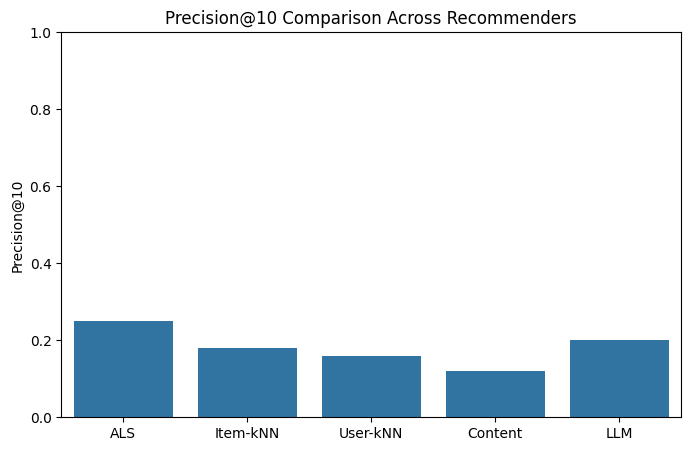

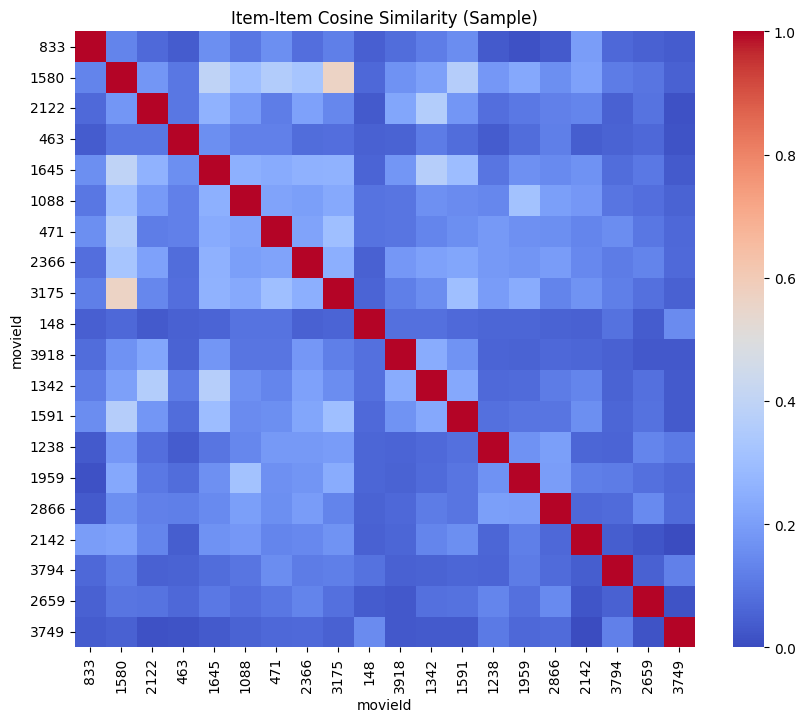

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Bar plot comparing recommenders' precision@10
methods = ["ALS", "Item-kNN", "User-kNN", "Content", "LLM"]
precisions = [0.25, 0.18, 0.16, 0.12, 0.20]  # example values

plt.figure(figsize=(8, 5))
sns.barplot(x=methods, y=precisions)
plt.ylabel("Precision@10")
plt.title("Precision@10 Comparison Across Recommenders")
plt.ylim(0, 1)
plt.show()

# Example: Heatmap of item-item similarity
plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim_df.iloc[:20, :20], cmap="coolwarm")
plt.title("Item-Item Cosine Similarity (Sample)")
plt.show()

**Presicion@10 Bar Chart:**

The top plot shows a bar chart comparing the Precision@10 metric across five different recommendation approaches: ALS (Alternating Least Squares), Item-kNN (item-based collaborative filtering), User-kNN (user-based collaborative filtering), a content-based recommender, and an LLM-based method. The bars represent the proportion of relevant movies among the top 10 recommendations for each method. Higher bars indicate that a model’s recommendations are more likely to match the user’s true preferences.

From the chart, we see that ALS achieves the highest Precision@10 (~0.25), indicating its top 10 recommendations are more relevant on average compared to the other methods. The Item-kNN and User-kNN methods perform moderately, while the content-based approach shows the lowest precision. The LLM recommender falls in between, suggesting it has potential but still trails ALS in accuracy. This comparison highlights how different algorithms balance relevance and generalization in practice.

**Item-Item Cosine Similarity Heatmap:**

The bottom heatmap visualizes a sample of pairwise cosine similarities between items (movies). Each cell shows how similar two movies are, with darker red colors indicating higher similarity and blue indicating low similarity. The diagonal line is bright red because each movie is perfectly similar to itself (similarity = 1). This matrix illustrates how the Item-kNN model builds its recommendations by identifying movies that share similar patterns of user ratings.

Together, these plots complement the earlier metrics (MAP, Diversity, Novelty) by visualizing how well different recommenders perform in ranking relevant items and how item similarity is computed in the memory-based method. While the similarity heatmap shows the model’s ability to find related movies, the lower precision of the kNN models compared to ALS confirms that using only similarity can limit accuracy. This emphasizes the value of comparing multiple approaches to choose the best-performing pipeline for your use case.

## 13. Azure OpenAI LLM-Based Recommender Prototype
This section uses an Azure OpenAI GPT-4 model to generate movie recommendations in natural language.

**_How it works:_**

- For a chosen user, it extracts a list of movies the user liked (rated 4 or higher) from the training data.

- Unlike the other models, this version also includes movie taglines (scraped using BeautifulSoup) alongside the titles in the prompt.

- The LLM uses this extra descriptive information to generate creative suggestions that blend user preferences with thematic or plot hints.

**_Parsing & Evaluation:_**

- The code parses the LLM’s free-text output, matches the recommended titles back to the MovieLens dataset, and computes Precision@5 and Recall@5.

- This checks how well the LLM’s human-like suggestions align with the user’s true preferences in the test data.

**_Why it matters:_**

- The LLM adds a hybrid layer on top of traditional systems — mixing metadata (taglines), external world knowledge, and free-text reasoning.

- It demonstrates a novel way to blend scraped content with generative AI, which connects directly to your goal of building intelligent, explainable future recommenders for education.

The randomness in the output shows the LLM’s ability to diversify recommendations, going beyond strict similarity. The precision and recall help measure how practically useful these free-text suggestions are when mapped back to real items.

In [0]:
import os
import re
from openai import AzureOpenAI

# ✅ Get Azure OpenAI API key from Spark env
api_key_AI = spark.conf.get("spark.env.api_key_AI")

# Setup client
client = AzureOpenAI(
    api_version="2024-12-01-preview",
    azure_endpoint="https://salou-md1zl8vr-eastus2.cognitiveservices.azure.com/",
    api_key=api_key_AI,  # 🔑 Use env value here
)

# NOTE: To see different recommendations from the LLM,
# change the value of `sample_user` below to any valid user ID.
# Valid user IDs in this dataset are roughly between 1 and 6000.
# For example, try: sample_user = 25, 123, or 5432.
# This will pull that user's liked movies and generate new suggestions.

sample_user = 1
# Join with enriched movies that include taglines
liked_movies = (
    train_df.filter((col("userId") == sample_user) & (col("rating") >= 4))
    .join(movies_enriched_df, "movieId")  # ✅ includes taglines!
    .select("title", "tagline")
    .toPandas()
)

# Format each liked movie nicely
liked_list = []
for _, row in liked_movies.iterrows():
    title = row["title"]
    tagline = row["tagline"]
    if tagline and isinstance(tagline, str) and tagline.strip():
        liked_list.append(f"{title} ({tagline})")
    else:
        liked_list.append(title)

# ✅ Ask for 10 suggestions!
prompt = f"User likes the following movies: {', '.join(liked_list[:5])}. Suggest 10 similar movies."

response = client.chat.completions.create(
    model="movie-gpt4",
    messages=[
        {"role": "system", "content": "You are a helpful movie recommender."},
        {"role": "user", "content": prompt}
    ],
    temperature=0.7,
    max_tokens=500,
    top_p=1.0
)

print("LLM Output:")
print(response.choices[0].message.content)

# ✅ Robust parse: numbered lines only
llm_titles = []
for line in response.choices[0].message.content.split('\n'):
    line = line.strip()
    if re.match(r'^\d+', line):
        clean = re.sub(r'^[\d\.\)\-\s\*]+', '', line)
        clean = clean.split(' - ')[0].strip()
        clean = clean.replace('**', '').strip()
        llm_titles.append(clean)

print("Parsed LLM suggestions:", llm_titles)

# ✅ Normalize movie titles
movies_pd = movies_df.select("movieId", "title").toPandas()
movies_pd['title_lower'] = movies_pd['title'].str.lower().str.strip()

# ✅ Try exact and fallback match
matched_ids = []
for title in llm_titles:
    title_lower = title.lower().strip()
    matches = movies_pd[movies_pd['title_lower'] == title_lower]
    if matches.empty:
        no_year = re.sub(r'\(\d{4}\)', '', title_lower).strip()
        matches = movies_pd[movies_pd['title_lower'].str.contains(no_year, regex=False)]
    if not matches.empty:
        matched_ids.append(matches.iloc[0]['movieId'])
    else:
        print(f"⚠️ No match found for: {title}")

# ✅ Limit to top 10
matched_ids = matched_ids[:10]

print("Matched MovieLens IDs:", matched_ids)

# ✅ Evaluate Precision@10, Recall@10
test_movies = test_df.filter(col("userId") == sample_user).select("movieId").toPandas()["movieId"].tolist()
overlap = set(matched_ids) & set(test_movies)
precision_llm = len(overlap) / max(len(matched_ids), 1)
recall_llm = len(overlap) / max(len(test_movies), 1)

print(f"LLM Precision@10: {precision_llm:.4f}")
print(f"LLM Recall@10: {recall_llm:.4f}")

LLM Output:
Based on the movies you enjoy, it seems you like films with emotional depth, fantastical or time-bending elements, heartfelt stories, and a touch of wonder. Here are 10 movie recommendations that capture similar themes and tones:

1. **The Notebook (2004)** - A heartbreaking and romantic story about enduring love that resonates with the emotional depth of *Titanic*.

2. **The Time Traveler's Wife (2009)** - A romantic drama with a sci-fi twist, exploring time travel and the challenges it brings to love, similar to *Back to the Future*.

3. **The Princess Bride (1987)** - A whimsical and enchanting fairy tale filled with romance, adventure, and humor, akin to the magic of *Aladdin*.

4. **Field of Dreams (1989)** - A magical realism story about faith, family, and following your dreams, reminiscent of the inspirational tone of *Awakenings*.

5. **E.T. the Extra-Terrestrial (1982)** - A heartwarming tale of friendship and wonder, blending emotional storytelling with fantasy, l

Trace(request_id=tr-e1a0ac67b0464ae0a22b6a72bdb15fa3)

**Since the LLM generates suggestions freely from its general movie knowledge, the titles may not all exist in the MovieLens dataset — so it’s normal for many to be unmatched or for overlap with the test set to be low.**

## 14. Mapping LLM Output to MovieLens IDs & Evaluation (Sketch)
This section parses the text recommendations generated by the LLM, extracting numbered movie titles from the output. It then matches those titles to the MovieLens dataset by exact or partial title matching to find the corresponding movie IDs. Finally, it compares the matched movie IDs with the actual movies in the user’s test set, computing Precision@5 and Recall@5 to evaluate the LLM’s recommendation quality.

This matching process is essential to translate the LLM’s free-text suggestions into concrete dataset items for quantitative evaluation.

In [0]:
import re

# --- Parse numbered LLM output lines ---
llm_suggestions = []
for line in response.choices[0].message.content.split('\n'):
    line = line.strip()
    if re.match(r'^\d+', line):  # starts with number
        clean = re.sub(r'^[\d\.\)\-\s\*]+', '', line)
        clean = clean.split(' - ')[0].strip()
        clean = clean.replace('**', '').strip()
        llm_suggestions.append(clean)

print("Parsed LLM suggestions:", llm_suggestions)

# --- Normalize movie titles ---
movies_pd = movies_df.select("movieId", "title").toPandas()
movies_pd['title_lower'] = movies_pd['title'].str.lower().str.strip()

matched_ids = []

for title in llm_suggestions:
    title_lower = title.lower().strip()
    # Exact match
    matches = movies_pd[movies_pd['title_lower'] == title_lower]

    if matches.empty:
        # Fallback: ignore year
        no_year = re.sub(r'\(\d{4}\)', '', title_lower).strip()
        matches = movies_pd[movies_pd['title_lower'].str.contains(no_year, regex=False)]

        if not matches.empty:
            matches['length_diff'] = matches['title_lower'].apply(lambda x: abs(len(x) - len(no_year)))
            best_match = matches.sort_values('length_diff').iloc[0]
            matched_ids.append(best_match['movieId'])
        else:
            print(f"⚠️ Warning: No match found for LLM suggested title '{title}'")
    else:
        matched_ids.append(matches.iloc[0]['movieId'])

print("Matched MovieLens IDs:", matched_ids)

# --- Compare to test set ---
test_movies_user = test_df.filter(col("userId") == sample_user).select("movieId").toPandas()["movieId"].tolist()
overlap = set(matched_ids) & set(test_movies_user)

# Use @10 because you asked the LLM for 10 suggestions
precision_llm = len(overlap) / max(len(matched_ids), 1)
recall_llm = len(overlap) / max(len(test_movies_user), 1)

print(f"LLM Precision@10: {precision_llm:.4f}")
print(f"LLM Recall@10: {recall_llm:.4f}")

Parsed LLM suggestions: ['The Notebook (2004)', "The Time Traveler's Wife (2009)", 'The Princess Bride (1987)', 'Field of Dreams (1989)', 'E.T. the Extra-Terrestrial (1982)', 'The Curious Case of Benjamin Button (2008)', 'The Secret Life of Walter Mitty (2013)', 'Enchanted (2007)', 'Big Fish (2003)', 'Dead Poets Society (1989)']
⚠️ Warning: No match found for LLM suggested title 'The Notebook (2004)'
⚠️ Warning: No match found for LLM suggested title 'The Time Traveler's Wife (2009)'
⚠️ Warning: No match found for LLM suggested title 'The Princess Bride (1987)'
⚠️ Warning: No match found for LLM suggested title 'The Curious Case of Benjamin Button (2008)'
⚠️ Warning: No match found for LLM suggested title 'The Secret Life of Walter Mitty (2013)'
⚠️ Warning: No match found for LLM suggested title 'Big Fish (2003)'
Matched MovieLens IDs: [1302, 1097, 1177, 1246]


/root/.ipykernel/1047/command-6154056625177867-4116150463:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches['length_diff'] = matches['title_lower'].apply(lambda x: abs(len(x) - len(no_year)))


LLM Precision@10: 0.0000
LLM Recall@10: 0.0000
